<a href="https://colab.research.google.com/github/jamelof23/ASL/blob/main/PrivAI4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fetch Codebase and Models

In [ ]:
import os
os.chdir('/content')
CODE_DIR = 'interfacegan'
!git clone https://github.com/genforce/interfacegan.git $CODE_DIR
os.chdir(f'./{CODE_DIR}')
!wget https://www.dropbox.com/s/qyv37eaobnow7fu/stylegan_ffhq.pth?dl=1 -O models/pretrain/stylegan_ffhq.pth --quiet

# Define Utility Functions

In [ ]:
import os.path
import io
import IPython.display
import numpy as np
import cv2
import PIL.Image

import torch

# A dictionary containing information about the models available (e.g., pggan, stylegan).
from models.model_settings import MODEL_POOL

from models.stylegan_generator import StyleGANGenerator


def build_generator(model_name):
  """Builds the generator by model name."""
  gan_type = MODEL_POOL[model_name]['gan_type']
  if gan_type == 'stylegan':
    generator = StyleGANGenerator(model_name)
  return generator

import cv2
import numpy as np
from PIL import Image
import IPython.display as display
import io

def imshow(image, viz_size=256):

    # Ensure the input is a single image
    if image.ndim != 3:
        raise ValueError("Input must be a single image with 3 dimensions (height, width, channels).")

    # Resize the image if necessary
    height, width, channels = image.shape
    if height != viz_size or width != viz_size:
        image = cv2.resize(image, (viz_size, viz_size))

    # Convert image to a displayable format
    image = np.asarray(image, dtype=np.uint8)
    data = io.BytesIO()
    Image.fromarray(image).save(data, 'jpeg')
    im_data = data.getvalue()

    # Display the image
    return display.display(display.Image(im_data))

# Select a Model

In [ ]:
# Fixed parameters
model_name = "stylegan_ffhq"  # Always use 'stylegan_ffhq'
latent_space_type = "W"       # Always use latent space type 'W'

# Function to build and load the generator model
generator = build_generator(model_name)

# List of attributes for manipulation
ATTRS = ['age', 'eyeglasses', 'gender', 'pose', 'smile']
# Dictionary to store attribute boundaries
boundaries = {}

# Loading Attribute Boundaries
for attr_name in ATTRS:
    boundary_name = f'{model_name}_{attr_name}'
    # Load the correct boundary file based on the latent space type
    boundary_path = f'boundaries/{boundary_name}_w_boundary.npy'
    boundaries[attr_name] = np.load(boundary_path)


# Upload latent codes

[INFO] Please upload your latent vector (.npy file):


Saving your_latent_vector.npy to your_latent_vector.npy


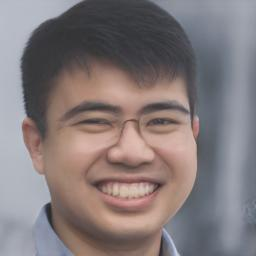

In [ ]:
import numpy as np
from google.colab import files

#num_samples = 1

# Upload the .npy file
print("[INFO] Please upload your latent vector (.npy file):")
uploaded = files.upload()

# Load the uploaded latent vector
npy_file_name = list(uploaded.keys())[0]
latent_codes = np.load(npy_file_name)

# Ensure that the latent vector is in the correct format (numpy.ndarray) and shape
if not isinstance(latent_codes, np.ndarray) or latent_codes.shape != (1, 512):
    raise ValueError(f"Latent codes must be a numpy.ndarray with shape (1, 512), but got {latent_codes.shape}")

# Use W space for StyleGAN synthesis
synthesis_kwargs = {'latent_space_type': 'W'}

# Generate the image using customized latent vector
images = generator.easy_synthesize(latent_codes, **synthesis_kwargs)['image']

# Extract the first image (assuming images has a batch dimension)
if images.ndim == 4:  # e.g., (batch_size, height, width, channels)
    images = images[0]

# Ensure the image is in the correct shape
if images.ndim != 3:
    raise ValueError(f"Generated image must have shape (height, width, channels), but got {images.shape}")

# Display the generated image
imshow(images)

# Adding Noise

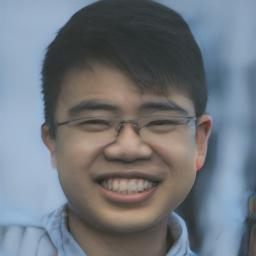

In [ ]:
import numpy as np

# Differential Privacy Parameters (Slider Values)
epsilon = 0.63  # @param {"type":"slider","min":0.01,"max":5,"step":0.01}
delta = 0.001  # @param {type:"slider", min:1e-7, max:1e-3, step:1e-7}
clipping_threshold = 5  # @param {type:"slider", min:0.1, max:5.0, step:0.1}

# Dropdown Menu for Attribute Selection
attribute_selection = "Age"  # @param ["Age", "Gender", "Both"]

# Function to add Gaussian noise for differential privacy
def add_gaussian_noise(epsilon, delta, boundary):
    """
    Adds Gaussian noise to a vector for differential privacy.

    Args:
        epsilon (float): Privacy budget.
        delta (float): Probability of failure.
        boundary (np.ndarray): Attribute boundary vector.

    Returns:
        np.ndarray: Noise scaled by boundary.
    """
    # Compute the standard deviation for Gaussian noise
    sigma = np.sqrt(2 * np.log(1.25 / delta)) / epsilon

    # Generate Gaussian noise
    noise = np.random.normal(0, sigma, boundary.shape)

    # Return the noise scaled by the boundary
    return boundary * noise

# Copy the original latent codes
new_codes = latent_codes.copy()

selected_attributes = []
# Map attribute_selection to the list of attributes to modify
if attribute_selection == "Age":
    selected_attributes = ["age"]
elif attribute_selection == "Gender":
    selected_attributes = ["gender"]
elif attribute_selection == "Both":
    selected_attributes = ["age", "gender"]
else:
    selected_attributes = []

# Add noise only to the selected attributes
for attr_name in selected_attributes:
    # Add Gaussian noise to the boundary
    noised_boundary = add_gaussian_noise(
        epsilon=epsilon,
        delta=delta,
        boundary=boundaries[attr_name]
    )

    # Add the noise-modified boundary to the latent codes
    new_codes += noised_boundary

# Apply clipping as the final step
new_codes = np.clip(new_codes, -clipping_threshold, clipping_threshold)

# Generate the new images
new_images = generator.easy_synthesize(new_codes, **synthesis_kwargs)['image']

# Ensure only a single image is passed to imshow
if new_images.ndim == 4:  # If batch dimension exists
    new_images = new_images[0]

# Validate the image shape
if new_images.ndim != 3:
    raise ValueError(f"Generated image must have shape (height, width, channels), but got {new_images.shape}")

# Display the new image
imshow(new_images)


# Adding projected Noise

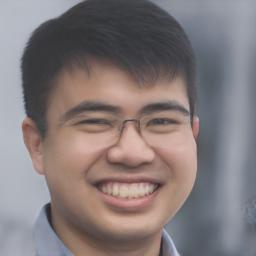

In [ ]:
import numpy as np

# Differential Privacy Parameters
epsilon = 14.72  # @param {"type":"slider","min":0.01,"max":100,"step":0.01}
delta = 0.001  # @param {type:"slider", min:1e-7, max:1e-3, step:1e-7}
clipping_threshold = 0.6  # @param {type:"slider", min:0.1, max:5.0, step:0.1}

# Dropdown Menu for Attribute Selection
attribute_selection = "Age"  # @param ["Age", "Gender", "Both"]

# Function to orthogonalize boundaries
def orthogonalize_boundaries(boundaries):

    """
    Orthogonalizes the attribute boundaries using Gram-Schmidt process.

    Args:
        boundaries (dict): Dictionary of attribute boundaries.

    Returns:
        dict: Dictionary of orthogonalized attribute boundaries.
    """

    orthogonal_boundaries = {}
    keys = list(boundaries.keys())
    for i, key_i in enumerate(keys):
        boundary_i = boundaries[key_i].copy()
        for j in range(i):
            key_j = keys[j]
            boundary_j = orthogonal_boundaries[key_j]
            projection = np.dot(boundary_i.flatten(), boundary_j.flatten()) / np.dot(boundary_j.flatten(), boundary_j.flatten())
            boundary_i -= projection * boundary_j
        orthogonal_boundaries[key_i] = boundary_i / np.linalg.norm(boundary_i)  # Normalize
    return orthogonal_boundaries

# Orthogonalize the boundaries
orthogonal_boundaries = orthogonalize_boundaries(boundaries)

# Function to add scalar noise
def add_scalar_noise(epsilon, delta):
    sigma = np.sqrt(2 * np.log(1.25 / delta)) / epsilon
    scalar_noise = np.random.normal(0, sigma)
    return scalar_noise

# Copy the original latent codes
new_codes = latent_codes.copy()

# Map attribute_selection to the list of attributes to modify
if attribute_selection == "Age":
    selected_attributes = ["age"]
elif attribute_selection == "Gender":
    selected_attributes = ["gender"]
elif attribute_selection == "Both":
    selected_attributes = ["age", "gender"]
else:
    selected_attributes = []


# Modify attributes with scalar noise
for attr_name in selected_attributes:
    # Retrieve the orthogonalized boundary for the attribute
    boundary = orthogonal_boundaries[attr_name]

    # Generate scalar noise
    scalar_noise = add_scalar_noise(epsilon, delta)

    # Add the noise-scaled boundary to the latent codes
    new_codes += boundary * scalar_noise

# Apply clipping as the final step
new_codes = np.clip(new_codes, latent_codes.min(), latent_codes.max())

# Generate the new images
new_images = generator.easy_synthesize(new_codes, **synthesis_kwargs)['image']

# Ensure only a single image is passed to imshow
if new_images.ndim == 4:  # If batch dimension exists
    new_images = new_images[0]

# Validate the image shape
if new_images.ndim != 3:
    raise ValueError(f"Generated image must have shape (height, width, channels), but got {new_images.shape}")

# Display the new image
imshow(new_images)




# Edit Attributes

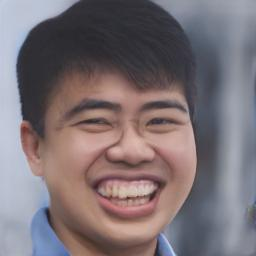

In [ ]:
#@title { display-mode: "form", run: "auto" }
# Assuming ATTRS and boundaries are defined earlier in your script
ATTRS = ['age', 'eyeglasses', 'gender', 'pose', 'smile']  # Example definition
# boundaries should be a dictionary with keys corresponding to ATTRS
# boundaries = {'age': ..., 'eyeglasses': ..., 'gender': ..., 'pose': ..., 'smile': ...}

# Slider values for attributes
age = 0  # @param {type:"slider", min:-3.0, max:3.0, step:0.1}
eyeglasses = 0  # @param {type:"slider", min:-2.9, max:3.0, step:0.1}
gender = 0  # @param {type:"slider", min:-3.0, max:3.0, step:0.1}
pose = 0  # @param {type:"slider", min:-3.0, max:3.0, step:0.1}
smile = 2  # @param {type:"slider", min:-3.0, max:3.0, step:0.1}

# Copying the original latent codes
new_codes = latent_codes.copy()

# Adding modifications based on attribute sliders
for attr_name in ATTRS:
    # Ensure attribute exists in boundaries and its slider value is valid
    if attr_name in boundaries:
        new_codes += boundaries[attr_name] * eval(attr_name)

# Generate the new image(s)
new_images = generator.easy_synthesize(new_codes, **synthesis_kwargs)['image']

# Extract and validate single image
if new_images.ndim == 4:  # If batch dimension exists
    new_images = new_images[0]  # Extract the first image

# Ensure the image has the correct shape
if new_images.ndim != 3:
    raise ValueError(f"Generated image must have shape (height, width, channels), but got {new_images.shape}")

# Display the image
imshow(new_images)
